# Predict age from AFQ-Browser-Demo data using AFQ-Insight

In [1]:
import afqinsight as afqi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle

from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook
from bokeh.embed import file_html
from bokeh.layouts import row, column, widgetbox
from bokeh.models import BoxSelectTool, ColorBar, CustomJS, HoverTool, Legend, Range1d, Title, Whisker
from bokeh.models.tickers import FixedTicker
from bokeh.models.annotations import LegendItem
from bokeh.palettes import Spectral10, Cividis256, Category10_10
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.resources import CDN
from bokeh.models.mappers import LinearColorMapper

from sklearn.decomposition import PCA

%matplotlib notebook

In [2]:
output_notebook()

Loading BokehJS ...

## Load the data

In [3]:
afq_data = afqi.load_afq_data(
    '../data/raw/age_data',
    target_cols=['Age'],
    scale_x=False
)

x, y, groups, columns, bias_index = (
    afq_data.x,
    afq_data.y['Age'],
    afq_data.groups,
    afq_data.columns,
    afq_data.bias_index
)

/Users/richford/projects/neuro/afq/insight/afqinsight/transform.py:145: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  features.columns.labels[metric_level].astype(np.int64) * n_tracts
/Users/richford/projects/neuro/afq/insight/afqinsight/transform.py:146: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  + features.columns.labels[tract_level].astype(np.int64),


In [4]:
np.linalg.cond(x)

243.16613916803428

## Find the optimal feature coefficients $\widehat{\beta}$

We search for the optimal coefficients using two different loss types: square loss and huber.

In [5]:
hp_cv_res_r2 = afqi.fit_hyperparams_cv(
    x, y, groups, bias_index=bias_index,
    n_splits=5, n_repeats=3,
    max_evals_per_cv=50, loss_type='square',
    beta0=None,
    score='r2',
    trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_r2',
    verbose=1, random_state=42, clf_threshold=0.5
)

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [6]:
hp_cv_res_medae = afqi.fit_hyperparams_cv(
    x, y, groups, bias_index=bias_index,
    n_splits=5, n_repeats=3,
    max_evals_per_cv=50,
    loss_type='square',
    beta0=hp_cv_res_r2[0].beta_hat,
    score='medae',
    trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_medae',
    verbose=1, random_state=42, clf_threshold=0.5
)

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [7]:
label_sets = afqi.multicol2sets(columns, tract_symmetry=True)
select_labels = [["fa"], ["md"]]
x_md_fa = afqi.select_groups(np.delete(x, bias_index, axis=1), select_labels, label_sets)
x_md_fa = np.hstack([x_md_fa, x[:, bias_index][:, np.newaxis]])

In [8]:
x_md_fa.shape

(77, 4001)

In [9]:
y.shape

(77,)

In [10]:
hp_cv_res_medae_md_fa = afqi.fit_hyperparams_cv(
    x_md_fa, y, groups[0:40], bias_index=4000,
    n_splits=5, n_repeats=3,
    max_evals_per_cv=40,
    loss_type='square',
    beta0=None,
    score='medae',
    trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_medae_md_fa_only',
    verbose=1, random_state=42, clf_threshold=0.5
)

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [11]:
# hp_cv_res_square = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=5, n_repeats=3,
#     max_evals_per_cv=50,
#     loss_type='square',
#     beta0=hp_cv_res_r2[0].beta_hat,
#     score='rmse',
#     trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_rmse',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [12]:
[(cv.eta, cv.transform_type) for cv in hp_cv_res_r2]

[(1.308333578022212, 'power'),
 (1.4451756901947612, 'power'),
 (1.3448848510642792, 'power'),
 (1.0153552607604164, 'power'),
 (1.2870291126783182, 'power'),
 (1.003376067456136, 'power'),
 (1.057616305513259, 'power'),
 (1.1717808756628592, 'power'),
 (1.0038051760636006, 'power'),
 (1.5001004521848866, 'power'),
 (1.9572699983764492, 'power'),
 (1.376852897841195, 'power'),
 (1.005270870935569, 'exponentiation'),
 (1.084041717514223, 'power'),
 (1.0895019201978253, 'exponentiation')]

In [13]:
[(cv.eta, cv.transform_type) for cv in hp_cv_res_medae]

[(1.0600511810646331, 'exponentiation'),
 (1.0020598433267898, 'exponentiation'),
 (1.0068702080572887, 'exponentiation'),
 (1.02638042631787, 'exponentiation'),
 (1.025396676842336, 'exponentiation'),
 (1.0204869949808208, 'exponentiation'),
 (1.0061707663288886, 'exponentiation'),
 (1.0033298437899174, 'exponentiation'),
 (1.0025555027408934, 'exponentiation'),
 (1.0047972784439696, 'exponentiation'),
 (1.0172186252893334, 'exponentiation'),
 (1.0796138633443433, 'exponentiation'),
 (1.0831778092905289, 'exponentiation'),
 (1.014264329050301, 'exponentiation'),
 (1.032262579033703, 'exponentiation')]

In [14]:
def print_results_summary(hp_cv_results):
    template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
    test = [r.test for r in hp_cv_results]
    train = [r.train for r in hp_cv_results]
    test_rmse = [t.rmse for t in test]
    test_r2 = [t.r2 for t in test]
    test_medae = [t.medae for t in test]
    train_medae = [t.medae for t in train]
    train_rmse = [t.rmse for t in train]
    train_r2 = [t.r2 for t in train]

    print('Statistic         mean   (variance)')
    print('--------------  ------- ------------')
    print(template.format(stat='test RMSE', mean=np.mean(test_rmse), var=np.var(test_rmse)))
    print(template.format(stat='test med AE', mean=np.mean(test_medae), var=np.var(test_medae)))
    print(template.format(stat='test R2', mean=np.mean(test_r2), var=np.var(test_r2)))
    print(template.format(stat='train RMSE', mean=np.mean(train_rmse), var=np.var(train_rmse)))
    print(template.format(stat='train med AE', mean=np.mean(train_medae), var=np.var(train_medae)))
    print(template.format(stat='train R2', mean=np.mean(train_r2), var=np.var(train_r2)))

In [15]:
# print_results_summary(hp_cv_res_square)

In [16]:
print_results_summary(hp_cv_res_r2)

Statistic         mean   (variance)
--------------  ------- ------------
test RMSE        8.4361 ( 4.9922)
test med AE      4.3653 ( 2.7166)
test R2          0.2479 (0.89732)
train RMSE      0.38994 (0.02015)
train med AE    0.35002 (0.047057)
train R2        0.99883 (5.534e-07)


In [17]:
print_results_summary(hp_cv_res_medae)

Statistic         mean   (variance)
--------------  ------- ------------
test RMSE        8.1646 ( 7.3006)
test med AE      3.4574 ( 4.3173)
test R2         0.36395 (0.34579)
train RMSE      0.60166 (0.0051277)
train med AE    0.51146 (0.0043223)
train R2        0.99746 (4.4173e-07)


In [18]:
print_results_summary(hp_cv_res_medae_md_fa)

Statistic         mean   (variance)
--------------  ------- ------------
test RMSE        8.1124 ( 5.7393)
test med AE      3.9324 ( 4.2993)
test R2         0.31205 (0.69847)
train RMSE       1.0444 ( 1.3156)
train med AE    0.83003 (0.20326)
train R2        0.98253 (0.0025155)


In [19]:
cv_results = [cv for cv in hp_cv_res_medae_md_fa]

test_set_y_hat = pd.concat([
    pd.Series(data=afqi.target_transformation(cv.test.x.dot(cv.beta_hat),
                                              eta=cv.eta,
                                              transform_type=cv.transform_type),
              index=cv.test.y.index,
              name='yhat')
    for cv in cv_results
]).groupby('subjectID').mean()

test_set_cv_idx = pd.concat([
    pd.Series(data=np.ones_like(cv.test.y.index) * idx,
              index=cv.test.y.index,
              name='cv_idx')
    for idx, cv in enumerate(cv_results)
]).apply(pd.to_numeric).groupby('subjectID').mean()

# test_set_cv_color = pd.concat([
#     pd.Series(data=np.ones_like(cv.test.y.index) * Spectral10[idx % 10],
#               index=cv.test.y.index,
#               name='cv_color')
#     for idx, cv in enumerate(cv_results)
# ])

test_set_rmse = pd.concat([
    pd.Series(data=np.ones_like(cv.test.y.index) * cv.test.rmse,
              index=cv.test.y.index,
              name='rmse')
    for cv in cv_results
]).apply(pd.to_numeric).groupby('subjectID').mean()

In [20]:
df_y = pd.concat([
    y,
    test_set_y_hat,
    test_set_cv_idx,
#     test_set_cv_color,
    test_set_rmse
], axis='columns', sort=True)
df_y['index'] = np.arange(len(y), dtype=np.int32)
df_y['stdres'] = (df_y['Age'] - df_y['yhat']) / (np.std(df_y['Age'] - df_y['yhat']))
df_y['res'] = df_y['Age'] - df_y['yhat']
df_y['size'] = 10 * df_y['rmse']
df_y['subject_id'] = df_y.index
df_y.head()

,Age,yhat,cv_idx,rmse,index,stdres,res,size,subject_id
subjectID,,,,,,,,,
subject_000,20,19.411938,7.666667,8.163825,0,0.073251,0.588062,81.638255,subject_000
subject_001,31,17.942245,7.000000,7.013543,1,1.626511,13.057755,70.135426,subject_001
subject_002,18,19.341283,8.333333,7.356130,2,-0.167074,-1.341283,73.561298,subject_002
subject_003,28,37.531578,6.333333,9.541370,3,-1.187280,-9.531578,95.413705,subject_003
subject_004,29,18.530056,6.333333,10.275905,4,1.304166,10.469944,102.759046,subject_004


In [21]:
p = figure(plot_width=600, plot_height=600, toolbar_location='above')
p.title.text = 'Residuals by subject'

source = ColumnDataSource(data=df_y)

hover = HoverTool(
    tooltips=[("Subject", "@subject_id"),
              ("Age", "@Age"),
              ("CV", "@cv_idx")],
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.circle(source=source,
         x='index',
         y='res',
#          color='cv_color',
         size='rmse',
         line_color=None)

p.xaxis.axis_label = 'Subject'
p.yaxis.axis_label = 'Residuals'

p.add_tools(hover)

# html = file_html(p, CDN, 'my plot')
# with open(op.abspath('../docs/img/bokeh_plots/regression_residuals_by_subject.html'), 'w') as fp:
#     fp.write(html)
show(p)

In [22]:
np.sqrt(np.square(df_y['res']).mean())

8.285362721970747

In [23]:
p = figure(plot_width=600, plot_height=600, toolbar_location='above', x_range=(0, 52), y_range=(0, 52))
p_res = figure(plot_width=600, plot_height=600, toolbar_location='above')
p.title.text = 'B'
p_res.title.text = 'Residuals for test splits'

source = ColumnDataSource(data=df_y)

hover = HoverTool(
    tooltips=[("Subject", "@subject_id"),
              ("Age", "@Age"),
              ("Residual", "@stdres"),
              ("CV", "@cv_idx")],
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.scatter(source=source,
          x='yhat',
          y='Age',
#           color='cv_color',
          size=10,
          line_color='black')

p.line(x=[0, 52], y=[0, 52], line_color="black", line_width=2, line_dash='dashed')

p_res.scatter(source=source,
              x='yhat',
              y='res',
#               color='cv_color',
              size='rmse',
              line_color=None)

p.xaxis.axis_label = 'Predicted Age'
p.yaxis.axis_label = 'Actual Age'
p.xaxis.axis_label_text_font_size = "16pt"
p.yaxis.axis_label_text_font_size = "16pt"
p.xaxis.major_label_text_font_size = "14pt"
p.yaxis.major_label_text_font_size = "14pt"
p.title.text_font_size = "16pt"

p_res.xaxis.axis_label = 'Predicted Age'
p_res.yaxis.axis_label = 'Standardized Residuals'

p.add_tools(hover)
p_res.add_tools(hover)

layout = row([p, p_res])

# html = file_html(layout, CDN, 'my plot')
# with open(op.abspath('../docs/img/bokeh_plots/regression_residuals_abs_power.html'), 'w') as fp:
#     fp.write(html)
show(layout)

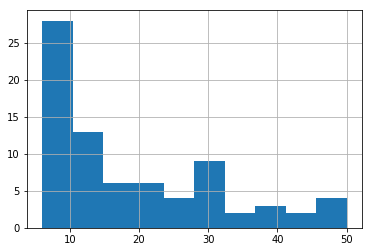

In [24]:
ax = y.hist()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

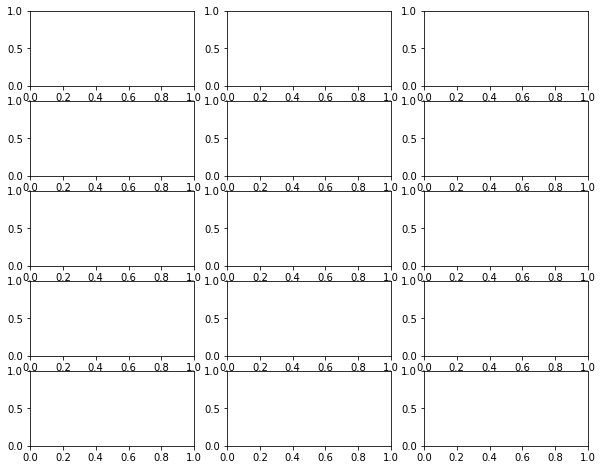

In [25]:
fig, ax = plt.subplots(5, 3, figsize=(10, 8))
_ = [cv.train.y.hist(alpha=0.5, ax=ax[idx % 5, idx // 5]) for idx, cv in enumerate(cv_results)]
_ = [cv.test.y.hist(alpha=1, ax=ax[idx % 5, idx // 5]) for idx, cv in enumerate(cv_results)]
_ = [ax[idx % 5, idx // 5].text(x=0.5, y=0.9, s=f"CV{idx}: RMSE={cv.test.rmse}",
                                horizontalalignment='center',
                                verticalalignment='center',
                                transform=ax[idx % 5, idx // 5].transAxes)
     for idx, cv in enumerate(cv_results)]

In [ ]:
print([np.count_nonzero(cv.beta_hat) / len(cv.beta_hat) for cv in cv_results])

In [ ]:
for cv in cv_results:
    print(cv.beta_hat[4000])

Using the hover tool on the chart above, we can see that subjects 05, 07, 16, 19, 30, 32, 35, 36 are all hard to classify (they are consistently closer to the classification threshold of 0.5). We should fire up the AFQ browser and look at how these subjects compare to the rest of the subjects in their group.

Here are links to a running instance of AFQ-Browser with the hard to classify subjects:
- [False negatives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=true&table[selectedRows][subject_007]=true&table[selectedRows][subject_016]=true&table[selectedRows][subject_019]=true&table[selectedRows][subject_030]=false&table[selectedRows][subject_032]=false&table[selectedRows][subject_035]=false&table[selectedRows][subject_036]=false&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.09355440414507772)
- [False positives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=false&table[selectedRows][subject_007]=false&table[selectedRows][subject_016]=false&table[selectedRows][subject_019]=false&table[selectedRows][subject_030]=true&table[selectedRows][subject_032]=true&table[selectedRows][subject_035]=true&table[selectedRows][subject_036]=true&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.09355440414507772)

# Feature Importance

Let's sort the features by their importance

In [ ]:
feature_dicts = afqi.multicol2dicts(columns, tract_symmetry=False)

mean_beta = np.mean(np.array(
    [np.delete(res.beta_hat, 4000) for res in hp_cv_res_medae_md_fa]
), axis=0)

var_beta = np.std(np.array(
    [np.delete(res.beta_hat, 4000) for res in hp_cv_res_medae_md_fa]
), axis=0)

sorted_features = afqi.sort_features(feature_dicts, mean_beta)

# sorted_features[0:50]

In [ ]:
columns_md_fa = columns.drop(['ad', 'cl', 'curvature', 'rd', 'torsion', 'volume'], level=0)
columns_md_fa = columns_md_fa.remove_unused_levels()

It's nice to see the top few features in a sorted list, but let's plot the features to get a feel for their distributions

In [ ]:
beta_hats = afqi.beta_hat_by_groups(mean_beta, columns=columns_md_fa, drop_zeros=True)
beta_hats_var = afqi.beta_hat_by_groups(var_beta, columns=columns_md_fa, drop_zeros=True)
# beta_hats_converged = afqi.beta_hat_by_groups(mean_beta_converged, columns=columns, drop_zeros=True)

First let's plot the coefficients themselves

In [ ]:
# afqi.plot.plot_betas(beta_hat=beta_hats, columns=columns)

In [ ]:
unfolded_beta = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=mean_beta,
    columns=columns_md_fa
)

unfolded_beta_var = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=var_beta,
    columns=columns_md_fa
)

In [99]:
afqi.plot.plot_unfolded_beta(
    unfolded_beta=unfolded_beta,
    output_html='../docs/img/bokeh_plots/regression_unfolded_beta.html',
    width=1500,
    height=800
)

In [100]:
afqi.plot.plot_unfolded_beta(
    unfolded_beta=unfolded_beta_var,
    output_html='../docs/img/bokeh_plots/regression_unfolded_beta_variance.html',
    width=1500,
    height=800
)

In [ ]:
from dipy.viz import window, actor
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from dipy.tracking.streamline import transform_streamlines

import json

In [ ]:
with open("../data/raw/core_streamlines.json") as fp:
    cores = json.load(fp)

In [ ]:
colors.shape

In [ ]:
renderer = window.Renderer()

metric = "fa"
colors = np.concatenate([beta_hats[bn][metric] for bn in beta_hats.keys()])
bundle_names = beta_hats.keys()
bundles = [np.array(cores[bn]["coreFiber"]) for bn in bundle_names]
stream_actor = actor.line(
    lines=bundles,
    colors=actor.create_colormap(colors, name='coolwarm'),
    linewidth=20,
    spline_subdiv=300,
    fake_tube=True,
)

renderer.add(stream_actor)
window.show(renderer, size=(900, 900), reset_camera=True)

In [108]:
y.max()

50